In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import emcee
import pandas as pd
import time
from multiprocessing import Pool
import corner

In [2]:
N = 50
names = ['Rv_6-9_all','Rv_6-9_S','Rv_6-9_R',
         'Rv_9-50_all','Rv_9-50_S','Rv_9-50_R']

In [3]:
r = {}
delta = {}
cov_delta = {}

In [4]:
for n in names:
    try:
        with fits.open(f'results/density_mice_Rv{n[3:6]}_z02-04_type{n[7:]}.fits') as p:
            r[n] = p[1].data.r
            delta[n] = p[1].data.delta
            cov_delta[n] = p[2].data.cov_delta.reshape(N,N)
    except:
        with fits.open(f'results/density_mice_Rv{n[3:7]}_z02-04_type{n[8:]}.fits') as p:
            r[n] = p[1].data.r
            delta[n] = p[1].data.delta
            cov_delta[n] = p[2].data.cov_delta.reshape(N,N)

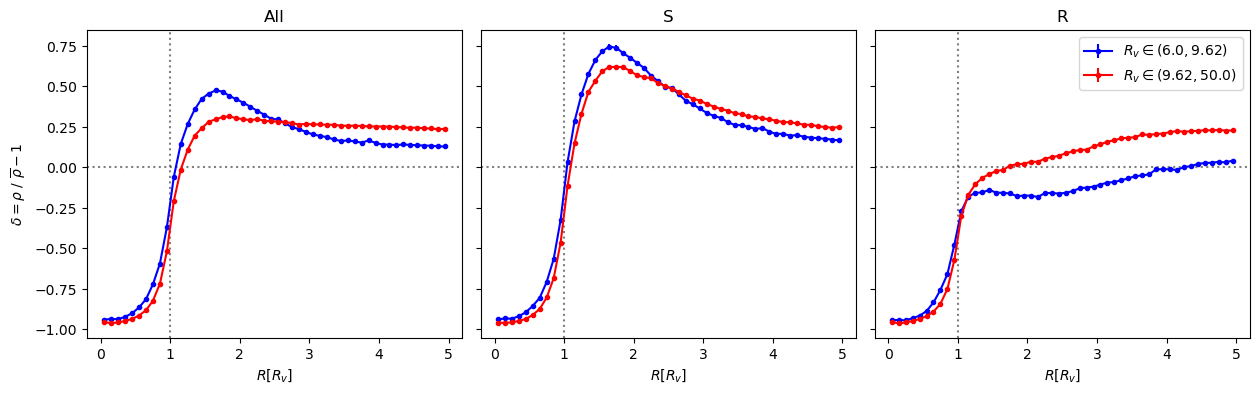

In [48]:
fig, axs = plt.subplots(1,3,
                       figsize=(15,4),
                       sharex=True, sharey=True)
for i,ax in enumerate(axs):
    ax.axhline(0, ls=':', c='k', alpha=0.5)
    ax.axvline(1, ls=':', c='k', alpha=0.5)

    ax.errorbar(r[names[i]], delta[names[i]], np.sqrt(np.diag(cov_delta[names[i]])), c='b', fmt='.-', label='$R_v \\in (6.0,9.62)$')
    ax.errorbar(r[names[i+3]], delta[names[i+3]], np.sqrt(np.diag(cov_delta[names[i+3]])), c='r', fmt='.-', label='$R_v \\in (9.62,50.0)$')

    ax.set_xlabel('$R [R_v]$')
axs[0].set_ylabel('$\\delta = \\rho \ / \ \\overline{\\rho} - 1$')
plt.legend()
axs[0].set_title('All')
axs[1].set_title('S')
axs[2].set_title('R')

plt.subplots_adjust(wspace=0.05, hspace=0.1)

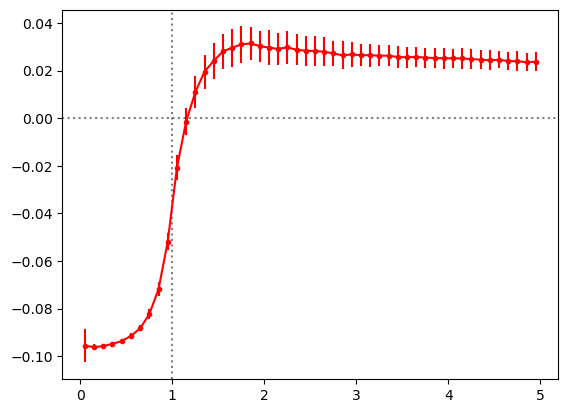

In [263]:
plt.errorbar(r[names[3]], delta[names[3]]*0.1, np.sqrt(np.diag(cov_delta[names[3]])), c='r', fmt='.-', label='$R_v \\in (9.62,50.0)$')
plt.axhline(0, ls=':', c='k', alpha=0.5)
plt.axvline(1, ls=':', c='k', alpha=0.5)

In [49]:
def hsw(r, rv, rs, a, b, dc):
    return dc*(1-(r/rs)**a)/(1+(r/rv)**b)

In [244]:
def log_likelihood(theta, x, y, iCs):
    model = hsw(x, *theta)
    return -np.dot((model - y), np.dot(iCs, (model - y)))

def log_prior(theta):
    rv1,rs1,a1,b1,delta1 = theta
    if (0.1 < rs1 < 5.0)&(0.1 < rv1 < 2.5)&(-1.5 <= delta1 < 0.)&(1. < a1 < 9.)&(1. < b1 < 20.)&(a1<=b1):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [277]:
def log_likelihood_R(theta, x, y, iCs):
    t1 = theta[:5]
    t2 = theta[5:]
    model = hsw(x, *t1) + hsw(x, *t2)

    return -np.dot((model - y), np.dot(iCs, (model - y)))

def log_prior_R(theta):
    rv1,rs1,a1,b1,delta1 = theta[:5]
    rv2,rs2,a2,b2,delta2 = theta[5:]
    if (0.1 < rs1 < 2.5)&(0.1 < rv1 < 2.5)&(-1.5 <= delta1 < 0.)&(2. < a1 < 9.)&(1. < b1 < 20.)&(
       0.5 < rs2 < 5.)&(0.5 < rv2 < 5.)&(-0.5 <= delta2 < 0.2)&(1. < a2 < 10.)&(1. < b2 < 15.)&(a2<=b2)&(a1<=b1):
        return 0.0
    return -np.inf

def log_probability_R(theta, x, y, yerr):
    lp = log_prior_R(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_R(theta, x, y, yerr)

In [282]:
pos = np.array([
    np.random.uniform(1.1,1.2,32),
    np.random.uniform(1.0,1.2,32),       #rs
    np.random.uniform(2.,6.,32),        #alpha
    np.random.uniform(9.,12.,32),
    np.random.uniform(-1.2,-0.8,32),       #delta
    
    np.random.uniform(3.,5.,32),
    np.random.uniform(3.,5.,32),       #rs
    np.random.uniform(1.5,3.,32),        #alpha
    np.random.uniform(4.,5.,32),
    np.random.uniform(-0.25,-0.1,32),       #delta
]).T     

k = 5

nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_R, args=(r[names[k]], delta[names[k]], np.linalg.inv(cov_delta[names[k]])), pool=pool)
    start = time.time()
    # state = sampler.run_mcmc(pos, 50, progress=True)
    # sampler.reset()
    sampler.run_mcmc(pos, 10000, progress=True)
    end = time.time()
    multi_time = end - start
print(multi_time)

100%|████████████████████████████████████| 10000/10000 [00:43<00:00, 231.60it/s]


43.20154523849487


(192000, 10)


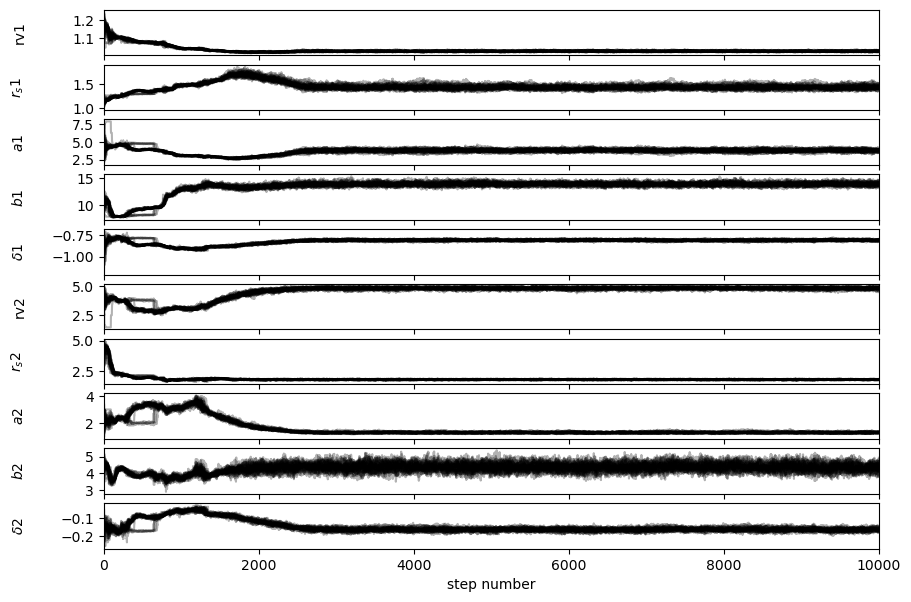

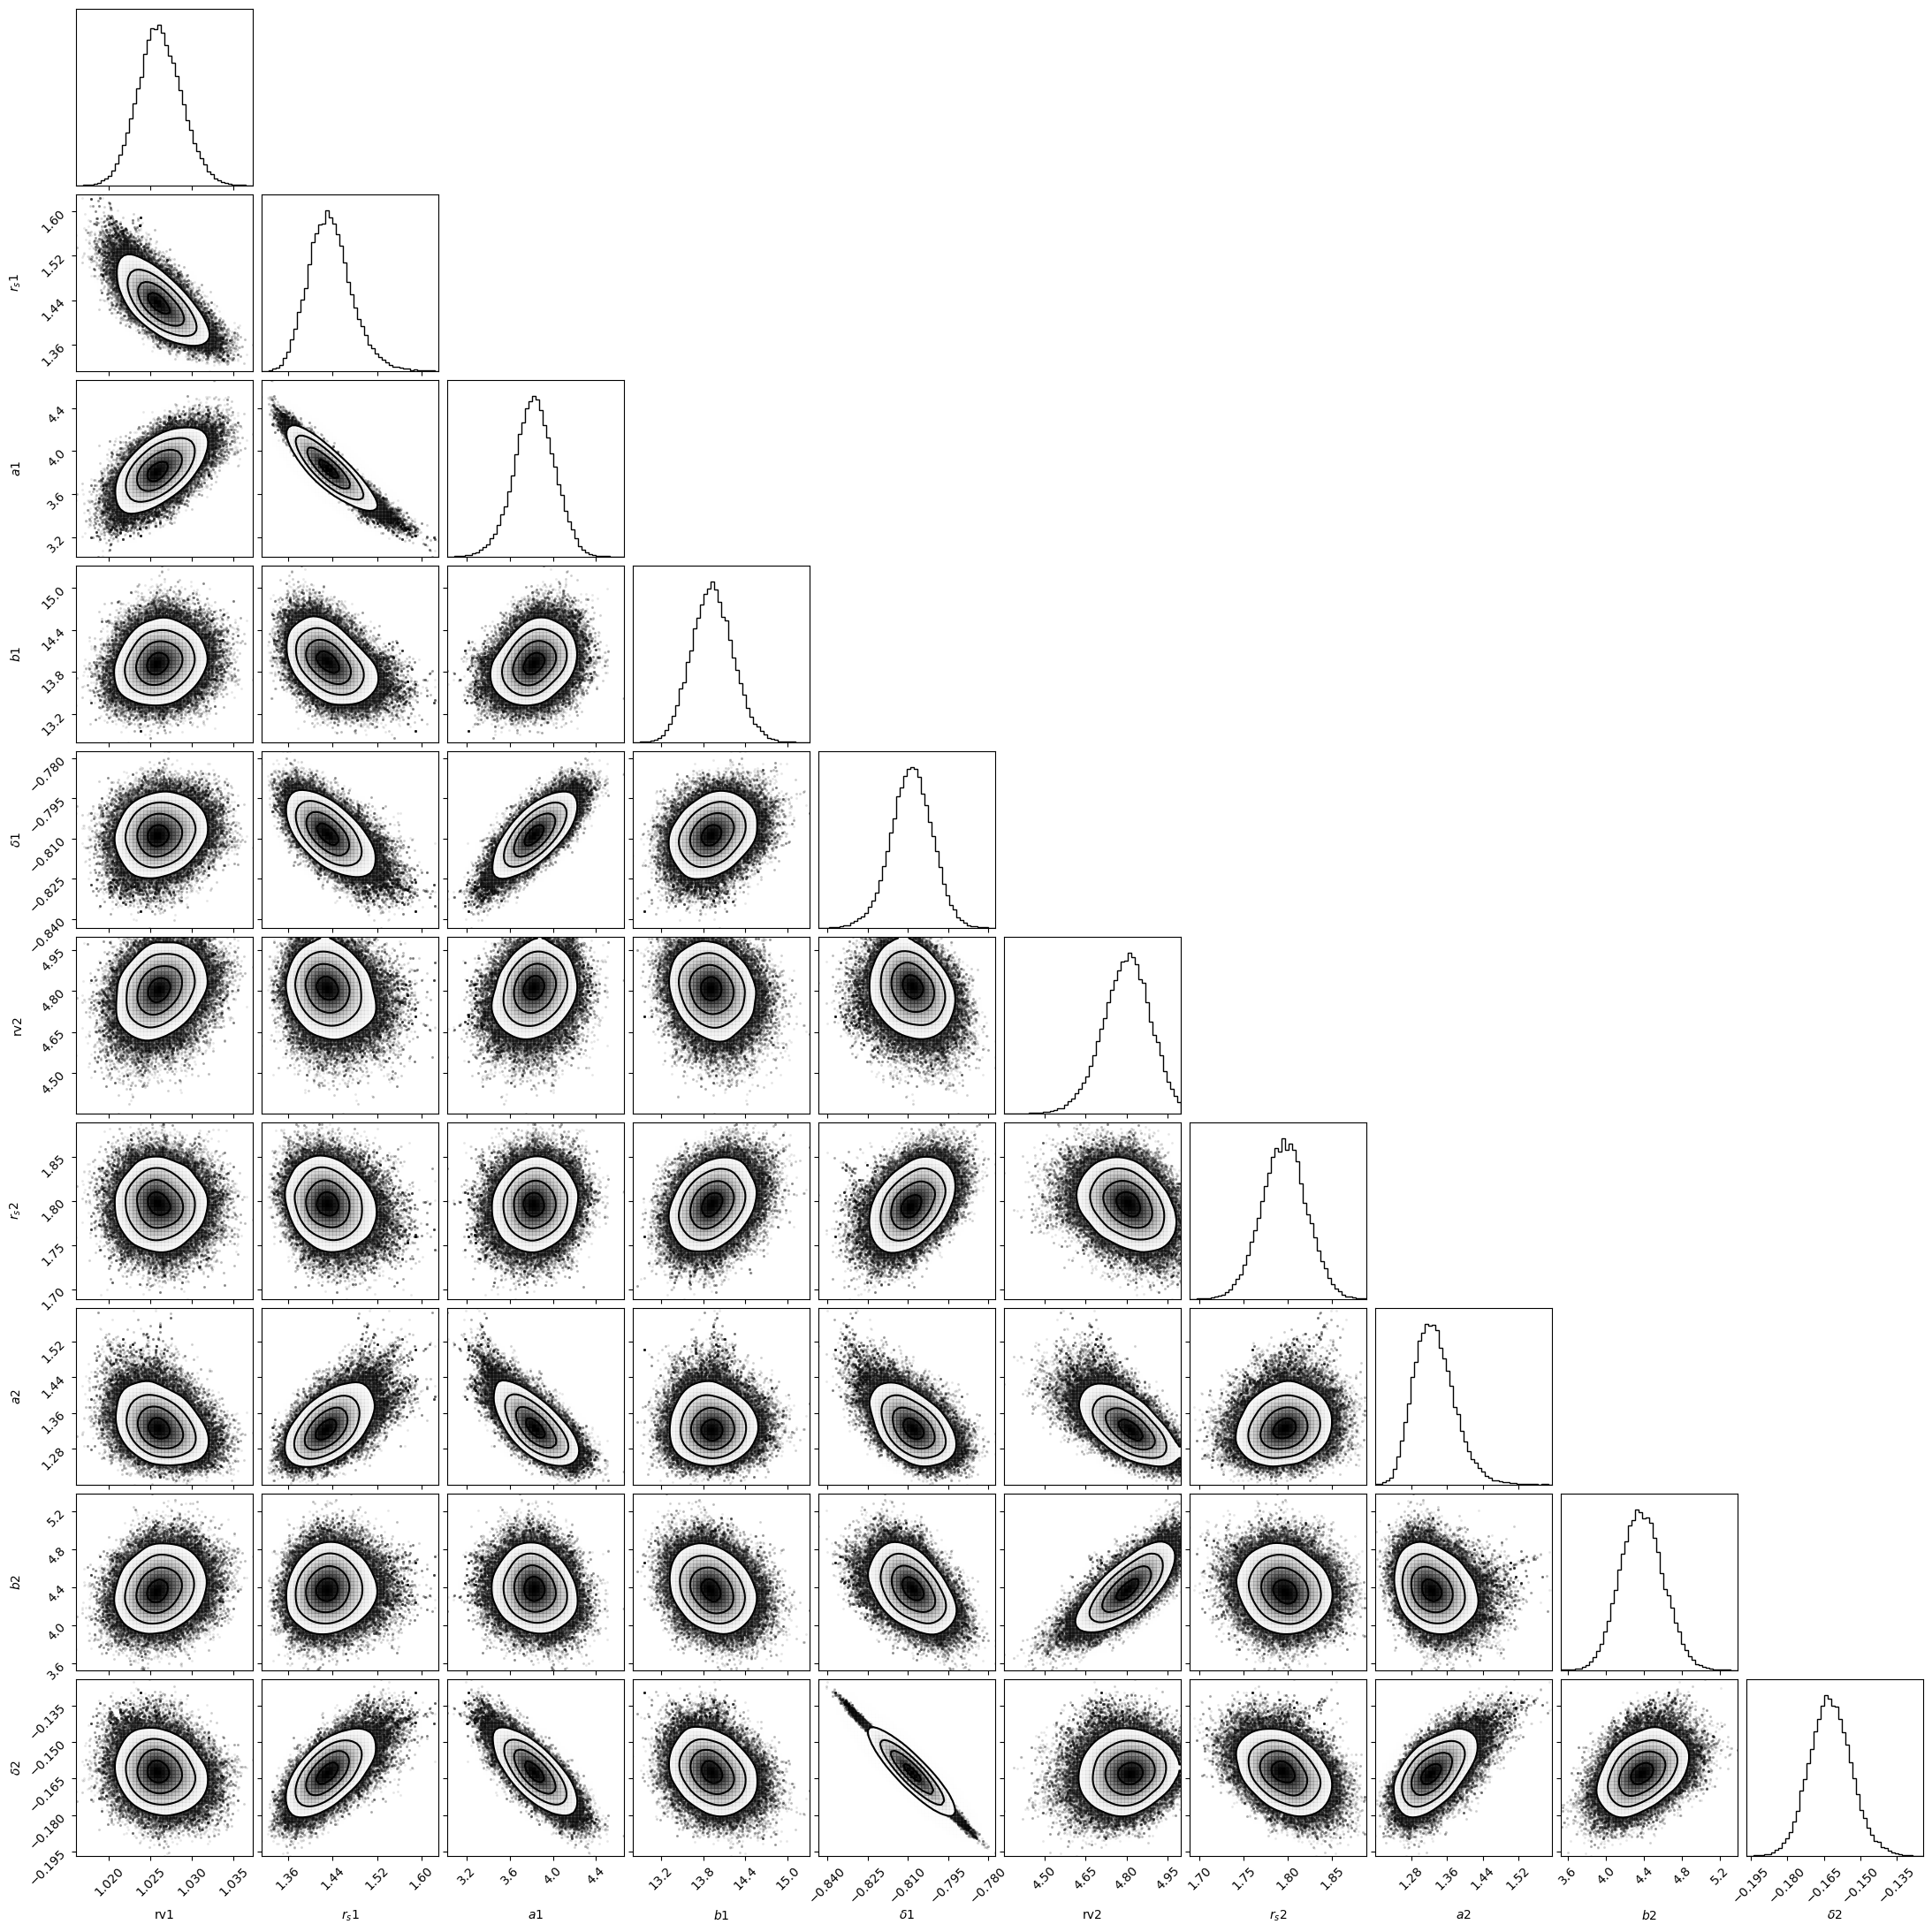

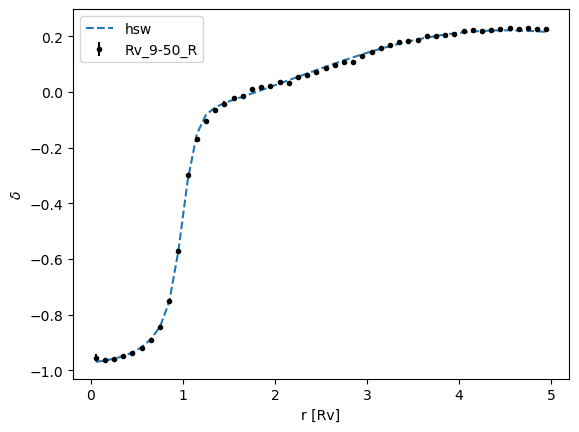

In [283]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['rv1',f'$r_s1$',f'$a1$', f'$b1$',f'$\delta1$',
         'rv2',f'$r_s2$',f'$a2$', f'$b2$',f'$\delta2$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

flat_samples = sampler.get_chain(discard=4000, thin=1, flat=True)
print(flat_samples.shape)

rv = np.percentile(flat_samples[:,0], [16, 50, 84])
rs = np.percentile(flat_samples[:,1], [16, 50, 84])
a  = np.percentile(flat_samples[:,2], [16, 50, 84])
b  = np.percentile(flat_samples[:,3], [16, 50, 84])
dc = np.percentile(flat_samples[:,4], [16, 50, 84])

rvLSS = np.percentile(flat_samples[:,5], [16, 50, 84])
rsLSS = np.percentile(flat_samples[:,6], [16, 50, 84])
aLSS  = np.percentile(flat_samples[:,7], [16, 50, 84])
bLSS  = np.percentile(flat_samples[:,8], [16, 50, 84])
dcLSS = np.percentile(flat_samples[:,9], [16, 50, 84])

fig = corner.corner(
    flat_samples, labels=labels, 
    bins=50,
    # truths=[rv[0],rs[0],a[0],b[0],dc[0]], 
    smooth=2.
);

plt.figure()
plt.plot(r[names[k]], hsw(r[names[k]], rv[1],rs[1],a[1],b[1],dc[1])+hsw(r[names[k]], rvLSS[1],rsLSS[1],aLSS[1],bLSS[1],dcLSS[1]),
         '--', label='hsw')
plt.errorbar(r[names[k]],delta[names[k]],np.sqrt(np.diag(cov_delta[names[k]])),
             fmt='.k', label=names[k])
plt.xlabel('r [Rv]')
plt.ylabel('$\\delta$')
plt.legend()
plt.show()

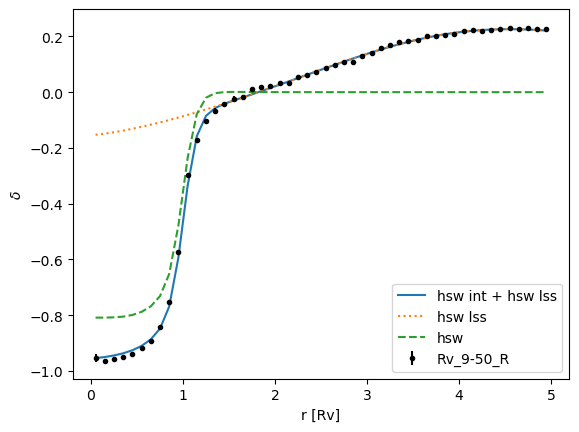

In [284]:
# plt.plot(r[names[0]], hsw(r[names[0]],rv[0],rs[0],a[0],b[0],dc[0]))
# plt.plot(r[names[0]], hsw(r[names[0]],rv[1],rs[1],a[1],b[1],dc[1]))
plt.plot(r[names[k]], hsw(r[names[k]], rv[2],rs[2],a[2],b[2],dc[2])+hsw(r[names[k]], rvLSS[2],rsLSS[2],aLSS[2],bLSS[2],dcLSS[2]), label='hsw int + hsw lss')
plt.plot(r[names[k]], hsw(r[names[k]], rvLSS[2],rsLSS[2],aLSS[2],bLSS[2],dcLSS[2]), ':', label='hsw lss')
plt.plot(r[names[k]], hsw(r[names[k]], rv[1],rs[1],a[1],b[1],dc[1]), '--', label='hsw')
plt.errorbar(r[names[k]],delta[names[k]],np.sqrt(np.diag(cov_delta[names[k]])), fmt='.k', label=names[k])
# plt.errorbar(r[names[0]],delta[names[0]],np.sqrt(np.diag(cov_delta[names[0]])), fmt='.r', label=names[0])
plt.xlabel('r [Rv]')
plt.ylabel('$\\delta$')
plt.legend()
plt.show()

In [280]:
def chi_red(ajuste,data,err,gl):
	'''
	Reduced chi**2
	------------------------------------------------------------------
	INPUT:
	ajuste       (float or array of floats) fitted value/s
	data         (float or array of floats) data used for fitting
	err          (float or array of floats) error in data
	gl           (float) grade of freedom (number of fitted variables)
	------------------------------------------------------------------
	OUTPUT:
	chi          (float) Reduced chi**2 	
	'''
		
	BIN=len(data)
	chi=((((ajuste-data)**2)/(err**2)).sum())/float(BIN-1-gl)
	return chi

In [285]:
chi = chi_red(hsw(r[names[k]], rv[1],rs[1],a[1],b[1],dc[1])+hsw(r[names[k]], rvLSS[1],rsLSS[1],aLSS[1],bLSS[1],dcLSS[1]),
              delta[names[k]],np.sqrt(np.diag(cov_delta[names[k]])), 10)

print(chi)

table_opt = np.array([
                        fits.Column(name='rv',format='D',array=flat_samples[:,0].flatten()),
                        fits.Column(name='rs',format='D',array=flat_samples[:,1].flatten()),
                        fits.Column(name='a' ,format='D',array=flat_samples[:,2].flatten()),
                        fits.Column(name='b' ,format='D',array=flat_samples[:,3].flatten()),
                        fits.Column(name='dc',format='D',array=flat_samples[:,4].flatten()),

                        fits.Column(name='rvLSS',format='D',array=flat_samples[:,5].flatten()),
                        fits.Column(name='rsLSS',format='D',array=flat_samples[:,6].flatten()),
                        fits.Column(name='aLSS' ,format='D',array=flat_samples[:,7].flatten()),
                        fits.Column(name='bLSS' ,format='D',array=flat_samples[:,8].flatten()),
                        fits.Column(name='dcLSS',format='D',array=flat_samples[:,9].flatten()),
                    ])

hdu = fits.Header()

hdu.append(('rv',rv[1]))
hdu.append(('rs',rs[1]))
hdu.append(('a',a[1]))
hdu.append(('b',b[1]))
hdu.append(('dc',dc[1]))

hdu.append(('rvLSS',rvLSS[1]))
hdu.append(('rsLSS',rsLSS[1]))
hdu.append(('aLSS',aLSS[1]))
hdu.append(('bLSS',bLSS[1]))
hdu.append(('dcLSS',dcLSS[1]))


hdu.append(('chi_red',chi))

primary_hdu = fits.PrimaryHDU(header=hdu)
tbhdu1 = fits.BinTableHDU.from_columns(table_opt)
hdul = fits.HDUList([primary_hdu, tbhdu1])

outfile = f'/home/fcaporaso/FlagShip/profiles/results/fitmcmc_2-HSW_density_mice_Rv10-50_z02-04_typeR.fits'
hdul.writeto(outfile, overwrite=True)

2.0776508037860575


# Plots

In [369]:
params = {}
chi = {}
err = {}
chains = {}
flat= {}

In [434]:
with fits.open('/home/fcaporaso/FlagShip/profiles/results/fitmcmc_density_mice_Rv6-10_z02-04_typeall.fits') as fit:
    params['Rv6-10_z02-04_typeall'] = dict(fit[0].header[4:-1])
    chi['Rv6-10_z02-04_typeall'] = fit[0].header[-1]
    err['Rv6-10_z02-04_typeall'] = {
        'RV': np.diff(np.percentile(fit[1].data.rv,[16,50,84])),
        'RS': np.diff(np.percentile(fit[1].data.rs,[16,50,84])),
        'A': np.diff(np.percentile(fit[1].data.a,[16,50,84])),
        'B': np.diff(np.percentile(fit[1].data.b,[16,50,84])),
        'DC': np.diff(np.percentile(fit[1].data.dc,[16,50,84])),
    }
    chains['Rv6-10_z02-04_typeall'] = {
        'RV': fit[1].data.rv.reshape(6000,32),
        'RS': fit[1].data.rs.reshape(6000,32),
        'A': fit[1].data.a.reshape(6000,32),
        'B': fit[1].data.b.reshape(6000,32),
        'DC': fit[1].data.dc.reshape(6000,32),
    }
    flat['Rv6-10_z02-04_typeall'] = np.column_stack([fit[1].data.rv,fit[1].data.rs,fit[1].data.a,fit[1].data.b,fit[1].data.dc])

In [425]:
with fits.open('/home/fcaporaso/FlagShip/profiles/results/fitmcmc_density_mice_Rv6-10_z02-04_typeS.fits') as fit:
    params['Rv6-10_z02-04_typeS'] = dict(fit[0].header[4:-1])
    chi['Rv6-10_z02-04_typeS'] = fit[0].header[-1]
    err['Rv6-10_z02-04_typeS'] = {
        'RV': np.diff(np.percentile(fit[1].data.rv,[16,50,84])),
        'RS': np.diff(np.percentile(fit[1].data.rs,[16,50,84])),
        'A': np.diff(np.percentile(fit[1].data.a,[16,50,84])),
        'B': np.diff(np.percentile(fit[1].data.b,[16,50,84])),
        'DC': np.diff(np.percentile(fit[1].data.dc,[16,50,84])),
    }
    chains['Rv6-10_z02-04_typeS'] = {
        'Rv': fit[1].data.rv.reshape(6000,32),
        'RS': fit[1].data.rs.reshape(6000,32),
        'A': fit[1].data.a.reshape(6000,32),
        'B': fit[1].data.b.reshape(6000,32),
        'DC': fit[1].data.dc.reshape(6000,32),
    }
    flat['Rv6-10_z02-04_typeS'] = np.column_stack([fit[1].data.rv,fit[1].data.rs,fit[1].data.a,fit[1].data.b,fit[1].data.dc])

In [386]:
with fits.open('/home/fcaporaso/FlagShip/profiles/results/fitmcmc_density_mice_Rv10-50_z02-04_typeS.fits') as fit:
    params['Rv10-50_z02-04_typeS'] = dict(fit[0].header[4:-1])
    chi['Rv10-50_z02-04_typeS'] = fit[0].header[-1]
    err['Rv10-50_z02-04_typeS'] = {
        'RV': np.diff(np.percentile(fit[1].data.rv,[16,50,84])),
        'RS': np.diff(np.percentile(fit[1].data.rs,[16,50,84])),
        'A': np.diff(np.percentile(fit[1].data.a,[16,50,84])),
        'B': np.diff(np.percentile(fit[1].data.b,[16,50,84])),
        'DC': np.diff(np.percentile(fit[1].data.dc,[16,50,84])),
    }
    chains['Rv10-50_z02-04_typeS'] = {
        'RV': fit[1].data.rv.reshape(6000,32),
        'RS': fit[1].data.rs.reshape(6000,32),
        'A': fit[1].data.a.reshape(6000,32),
        'B': fit[1].data.b.reshape(6000,32),
        'DC': fit[1].data.dc.reshape(6000,32),
    }
    flat['Rv10-50_z02-04_typeS'] = np.column_stack([fit[1].data.rv,fit[1].data.rs,fit[1].data.a,fit[1].data.b,fit[1].data.dc])

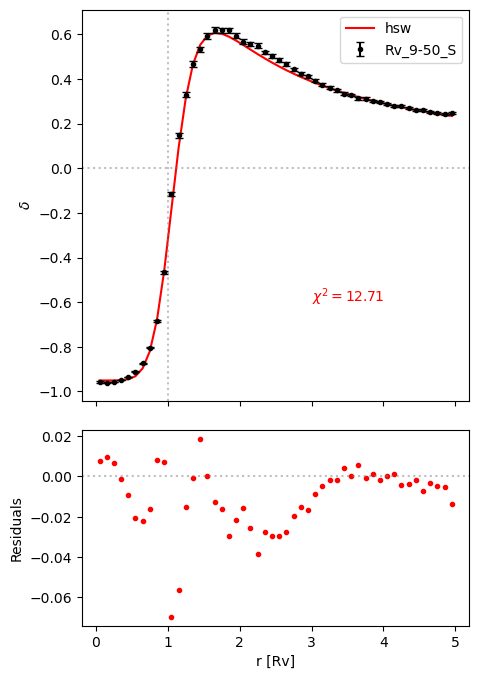

In [427]:
fig, (ax1,ax2) = plt.subplots(2,1,
                              gridspec_kw={'height_ratios':[2, 1]},
                              figsize=(5,8),
                              sharex=True)
ax1.plot(r[names[4]], hsw(r[names[4]], *params['Rv10-50_z02-04_typeS'].values()),
    c='r', label='hsw')
ax1.errorbar(r[names[4]],delta[names[4]],np.sqrt(np.diag(cov_delta[names[4]])),
             fmt='.k', label=names[4], capsize=3)

ax1.axhline(0,ls=':',c='grey',alpha=0.5)
ax1.axvline(1,ls=':',c='grey',alpha=0.5)

ax2.plot(r[names[4]], hsw(r[names[4]], *params['Rv10-50_z02-04_typeS'].values()) - delta[names[4]],
        '.r')
ax2.axhline(0,ls=':',c='grey',alpha=0.5)

ax2.set_xlabel('r [Rv]')
ax1.set_ylabel('$\\delta$')
ax2.set_ylabel('Residuals')
ax1.text(3,-0.6,f"$\\chi^2 = {chi['Rv10-50_z02-04_typeS']:.2f}$", c='r')

plt.subplots_adjust(wspace=0.05, hspace=0.1)

ax1.legend()
plt.show()

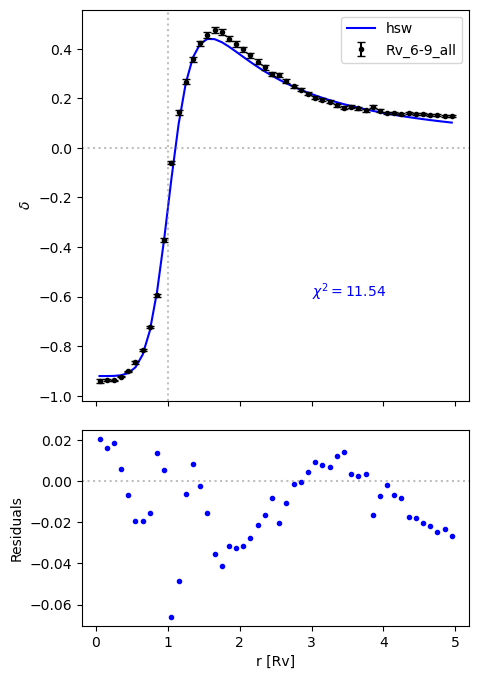

In [435]:
fig, (ax1,ax2) = plt.subplots(2,1,
                              gridspec_kw={'height_ratios':[2, 1]},
                              figsize=(5,8),
                              sharex=True)
ax1.plot(r[names[0]], hsw(r[names[0]], *params['Rv6-10_z02-04_typeall'].values()),
    c='b', label='hsw')
ax1.errorbar(r[names[0]],delta[names[0]],np.sqrt(np.diag(cov_delta[names[0]])),
             fmt='.k', label=names[0], capsize=3)

ax1.axhline(0,ls=':',c='grey',alpha=0.5)
ax1.axvline(1,ls=':',c='grey',alpha=0.5)

ax2.plot(r[names[0]], hsw(r[names[0]], *params['Rv6-10_z02-04_typeall'].values()) - delta[names[0]],
        '.b')
ax2.axhline(0,ls=':',c='grey',alpha=0.5)

ax2.set_xlabel('r [Rv]')
ax1.set_ylabel('$\\delta$')
ax2.set_ylabel('Residuals')
ax1.text(3,-0.6,f"$\\chi^2 = {chi['Rv6-10_z02-04_typeall']:.2f}$", c='b')

plt.subplots_adjust(wspace=0.05, hspace=0.1)

ax1.legend()
plt.show()

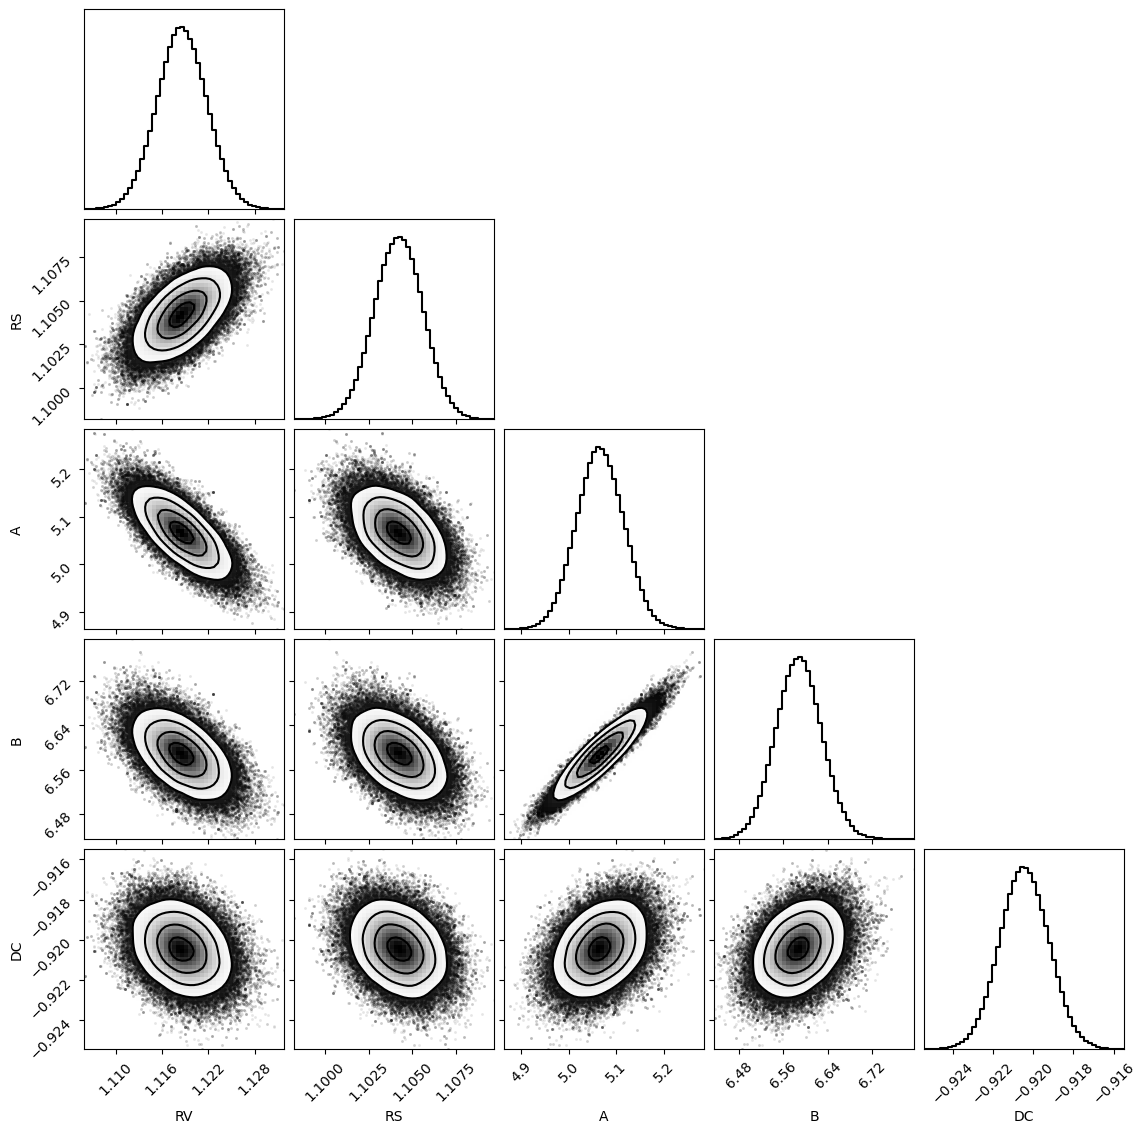

In [436]:
fig = corner.corner(
    flat['Rv6-10_z02-04_typeall'], labels=list(chains['Rv6-10_z02-04_typeall'].keys()), 
    bins=50,
    # truths=[rv[0],rs[0],a[0],b[0],dc[0]], 
    smooth=1.50, smooth1d=1.50, 
);

In [438]:
params['Rv6-10_z02-04_typeall']

{'RV': 1.118552680175074,
 'RS': 1.104213542267451,
 'A': 5.065897820219564,
 'B': 6.587854633533562,
 'DC': -0.9204441151655682}

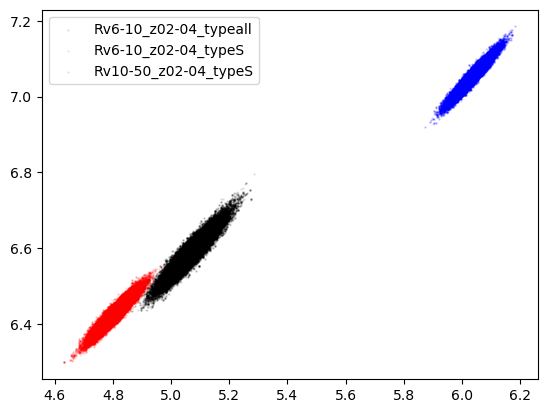

In [254]:
plt.scatter(chains['Rv6-10_z02-04_typeall']['a'],chains['Rv6-10_z02-04_typeall']['b'],
            alpha=0.1, c='k',s=0.5, label='Rv6-10_z02-04_typeall')
plt.scatter(chains['Rv6-10_z02-04_typeS']['a'],chains['Rv6-10_z02-04_typeS']['b'],
            alpha=0.1, c='r',s=0.5, label='Rv6-10_z02-04_typeS')
plt.scatter(chains['Rv10-50_z02-04_typeS']['a'],chains['Rv10-50_z02-04_typeS']['b'],
            alpha=0.1, c='b',s=0.5, label='Rv10-50_z02-04_typeS')

plt.legend()